# Assignment 5: Image Classification with CNNs
**Buinitskii Stanislav**

**Repository:** https://github.com/stasais/ndl/tree/assignment-5-done

---

## Dataset: AI-Generated Industrial Parts

For this project I chose to classify images of **industrial parts** — specifically bolts, carton boxes, cement bags, nuts, and washers. The dataset was generated using **Stable Diffusion XL 1.0** on an **NVIDIA RTX 4070**.

**Why this dataset?**
- Industrial part classification is a real-world application (quality control, warehouse automation)
- AI-generated data lets us control the dataset while simulating realistic variations 
- 5 classes with visually distinct but sometimes confusable objects (bolt vs. nut, nut vs. washer)
- Small dataset (500 train, 50 test) — a realistic scenario where transfer learning should shine

| Property | Value |
|----------|-------|
| Classes | bolt, carton_box, cement_bag, nut, washer |
| Train images | 500 (100 per class) |
| Test images | 50 (10 per class) |
| Original resolution | 1024 × 1024 RGB |
| Generator | SDXL 1.0 on RTX 4070 |

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use only first GPU
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

# Enable GPU memory growth to avoid OOM
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from utils import (
    train_model_ds, eval_classification, eval_classification_ds,
    plot_training_history, make_gradcam_heatmap, create_gradcam_visualization,
    show_gradcam_grid
)

import shutil
# Clean logs for fresh TensorBoard runs
if os.path.exists("logs"):
    shutil.rmtree("logs")
    print("Logs directory cleared")

SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
CLASS_NAMES = ['bolt', 'carton_box', 'cement_bag', 'nut', 'washer']
NUM_CLASSES = len(CLASS_NAMES)

TRAIN_DIR = 'training_images'
TEST_DIR = 'training_images_test'

print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

2026-02-13 19:55:41.519515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 19:55:41.550597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-13 19:55:42.294532: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow: 2.20.0
Keras: 3.13.1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Data Exploration

Let's visualize some samples from each class to understand what our models will need to learn.

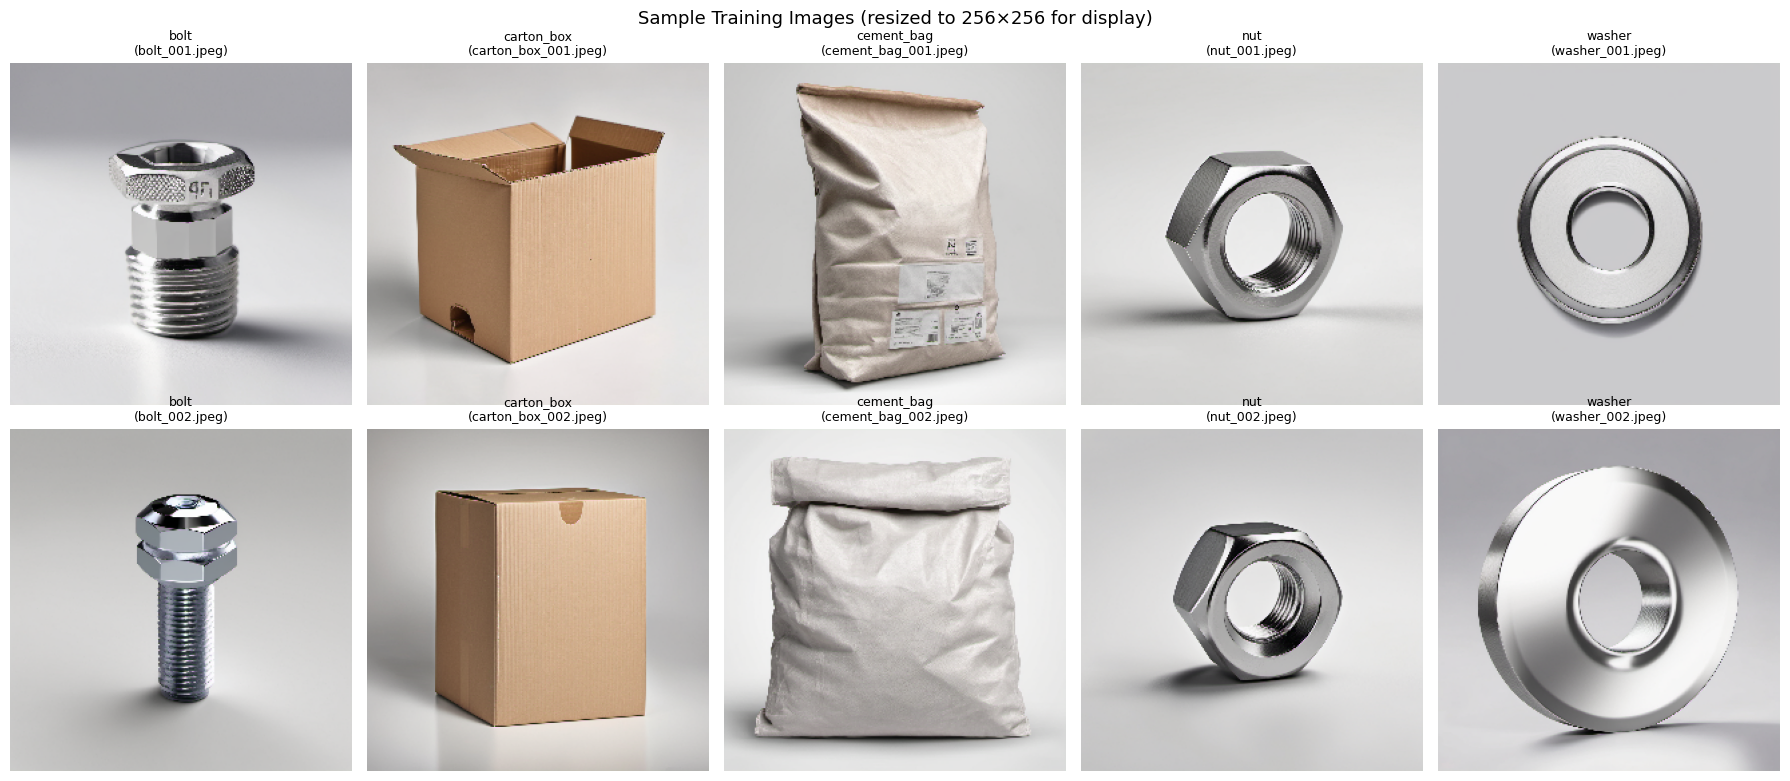


Class distribution (train):
  bolt           : 100 images
  carton_box     : 100 images
  cement_bag     : 100 images
  nut            : 100 images
  washer         : 100 images

Class distribution (test):
  bolt           : 10 images
  carton_box     : 10 images
  cement_bag     : 10 images
  nut            : 10 images
  washer         : 10 images


In [2]:
# Show sample images from each class (train set)
fig, axes = plt.subplots(2, 5, figsize=(18, 8))

for col, cls in enumerate(CLASS_NAMES):
    cls_dir = os.path.join(TRAIN_DIR, cls)
    img_files = sorted(os.listdir(cls_dir))[:2]  # first 2 images per class
    for row in range(2):
        img_path = os.path.join(cls_dir, img_files[row])
        img = keras.utils.load_img(img_path, target_size=(256, 256))
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{cls}\n({img_files[row]})", fontsize=9)
        axes[row, col].axis('off')

plt.suptitle('Sample Training Images (resized to 256×256 for display)', fontsize=13)
plt.tight_layout()
plt.show()

# Class distribution
print("\nClass distribution (train):")
for cls in CLASS_NAMES:
    n = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
    print(f"  {cls:15s}: {n} images")

print("\nClass distribution (test):")
for cls in CLASS_NAMES:
    n = len(os.listdir(os.path.join(TEST_DIR, cls)))
    print(f"  {cls:15s}: {n} images")

## 2. Preprocessing Pipeline

### Decisions and Reasoning

| Step | Choice | Reasoning |
|------|--------|-----------|
| **Resize** | 224×224 | Standard ImageNet input size, required for pretrained models. Also reasonable for custom CNN — large enough to preserve detail. |
| **Normalization** | [0, 1] for custom CNN; model-specific for pretrained | Custom CNN works well with simple [0,1] scaling. Pretrained models expect their original preprocessing (e.g., EfficientNet uses [-1, 1]). |
| **Train/Val split** | 80/20 from training set | We use `image_dataset_from_directory` with `validation_split=0.2`. The separate `training_images_test/` folder is held out for final evaluation only. |
| **Batch size** | 16 | Small dataset (500 images) — smaller batches give more gradient updates per epoch and add beneficial noise. |

### What we did NOT do (and why)
- **No grayscale conversion**: Color information helps distinguish classes (e.g., brown cement bags vs. metallic bolts)
- **No manual cropping**: SDXL images are already centered on the object
- **No class weighting**: Dataset is perfectly balanced (100 per class)

In [3]:
# Load datasets using image_dataset_from_directory
# This handles resizing, batching, and train/val splitting

train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

# Verify class names match
print(f"Train class names: {train_ds.class_names}")
print(f"Test class names:  {test_ds.class_names}")

# Count samples
train_count = sum(1 for _ in train_ds.unbatch())
val_count = sum(1 for _ in val_ds.unbatch())
test_count = sum(1 for _ in test_ds.unbatch())
print(f"\nTrain: {train_count}, Val: {val_count}, Test: {test_count}")

Found 500 files belonging to 5 classes.
Using 400 files for training.


I0000 00:00:1771008965.458859  102204 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2713 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:57:00.0, compute capability: 8.9


Found 500 files belonging to 5 classes.
Using 100 files for validation.
Found 50 files belonging to 5 classes.
Train class names: ['bolt', 'carton_box', 'cement_bag', 'nut', 'washer']
Test class names:  ['bolt', 'carton_box', 'cement_bag', 'nut', 'washer']


2026-02-13 19:56:06.606655: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-13 19:56:06.756178: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Train: 400, Val: 100, Test: 50


In [4]:
# Prepare numpy arrays for test evaluation (needed by eval_classification)
X_test_list, y_test_list = [], []
for images, labels in test_ds:
    X_test_list.append(images.numpy())
    y_test_list.append(labels.numpy())

X_test_raw = np.concatenate(X_test_list)      # float32 [0, 255]
y_test = np.concatenate(y_test_list)

X_test_scaled = X_test_raw / 255.0             # [0, 1] for custom CNN
print(f"X_test shape: {X_test_raw.shape}, y_test shape: {y_test.shape}")
print(f"X_test_raw range: [{X_test_raw.min():.1f}, {X_test_raw.max():.1f}]")
print(f"X_test_scaled range: [{X_test_scaled.min():.3f}, {X_test_scaled.max():.3f}]")

X_test shape: (50, 224, 224, 3), y_test shape: (50,)
X_test_raw range: [0.0, 255.0]
X_test_scaled range: [0.000, 1.000]


2026-02-13 19:56:17.593693: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 3. Data Augmentation

With only 100 images per class, data augmentation is **critical** to prevent overfitting.

### Augmentation Choices

| Augmentation | Used? | Reasoning |
|-------------|-------|-----------|
| **Horizontal Flip** | Yes | Parts can appear facing either direction |
| **Vertical Flip** | No | In a real industrial setting, objects are typically seen from above on a conveyor — vertical flip could create unrealistic orientations for some objects (e.g., cement bags) |
| **Rotation (±15%)** | Yes | Parts may be rotated slightly on a surface |
| **Zoom (±10%)** | Yes | Camera distance varies in practice |
| **Translation (±10%)** | Yes | Objects may not be perfectly centered |
| **Color Jitter** | No | Our SDXL images have consistent industrial lighting. Adding random color shifts to just 100 images per class risks introducing noise rather than useful variation |
| **Random Erasing** | No | Occluded industrial parts are rare in our use case |

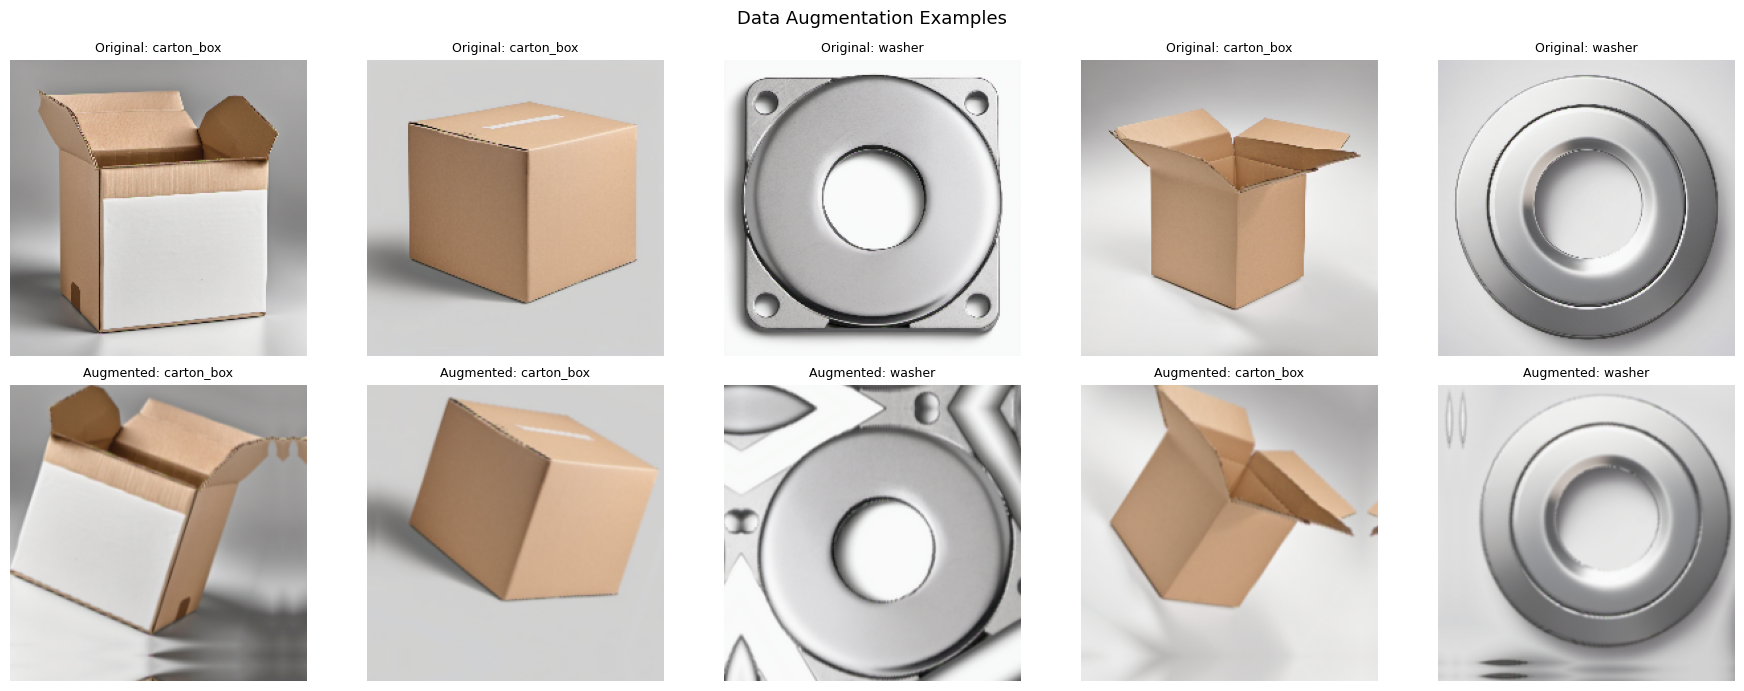

In [5]:
# Data augmentation layer (applied only during training)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")

# Visualize augmentation effect
sample_batch = next(iter(train_ds))
sample_images = sample_batch[0][:5]  # first 5 images
sample_labels = sample_batch[1][:5]

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
for i in range(5):
    # Original
    axes[0, i].imshow(sample_images[i].numpy().astype('uint8'))
    axes[0, i].set_title(f"Original: {CLASS_NAMES[sample_labels[i]]}", fontsize=9)
    axes[0, i].axis('off')
    
    # Augmented
    augmented = data_augmentation(tf.expand_dims(sample_images[i], 0))
    axes[1, i].imshow(augmented[0].numpy().astype('uint8'))
    axes[1, i].set_title(f"Augmented: {CLASS_NAMES[sample_labels[i]]}", fontsize=9)
    axes[1, i].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=13)
plt.tight_layout()
plt.show()

## 4. Model 1: Custom CNN from Scratch

### Architecture Design Rationale

Based on the CNN architecture from exercise 10 (CIFAR-10), but adapted for our larger 224×224 images and 5-class problem:

- **3 convolutional blocks** (vs. 2 in exercise 10) — needed because our input is 224×224 vs. 32×32. More pooling layers are required to reduce spatial dimensions.
- **Increasing filter counts** (32 → 64 → 128): Standard pattern — early layers capture edges/textures, deeper layers capture complex shapes.
- **BatchNormalization**: Stabilizes training and allows higher learning rates (from exercise 8).
- **GlobalAveragePooling2D instead of Flatten**: Dramatically reduces parameters (no massive Dense layer after flattening), acts as structural regularizer — important with only 500 images.
- **Dropout 0.4**: Aggressive dropout because of the small dataset size.
- **Adam optimizer, lr=1e-3**: Known to work well generally (confirmed in assignment 4).

In [6]:
# Prepare normalized datasets for custom CNN ([0, 1] range)
def normalize_to_01(image, label):
    return image / 255.0, label

train_ds_norm = train_ds.map(normalize_to_01, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_norm = val_ds.map(normalize_to_01, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_norm = test_ds.map(normalize_to_01, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_ds_norm = train_ds_norm.prefetch(tf.data.AUTOTUNE)
val_ds_norm = val_ds_norm.prefetch(tf.data.AUTOTUNE)
test_ds_norm = test_ds_norm.prefetch(tf.data.AUTOTUNE)

In [7]:
# Custom CNN architecture
inputs = keras.Input(shape=(224, 224, 3))

# Augmentation (only active during training)
x = data_augmentation(inputs)

# Block 1: 32 filters
x = layers.Conv2D(32, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 2: 64 filters
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 3: 128 filters
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

custom_cnn = keras.Model(inputs=inputs, outputs=outputs, name='custom_cnn')

custom_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

custom_cnn.summary()

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             

 Total params: 305,957 (1.17 MB)

 Trainable params: 305,061 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
# Train custom CNN
custom_cnn, custom_history = train_model_ds(
    custom_cnn, train_ds_norm, val_ds_norm,
    model_name='custom_cnn',
    epochs=60,
    early_stopping=True,
    patience=15
)

Epoch 1/60


2026-02-13 19:57:13.506680: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.4500 - loss: 1.2845 - val_accuracy: 0.1900 - val_loss: 1.6202
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5850 - loss: 0.9578 - val_accuracy: 0.1900 - val_loss: 1.6188
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6625 - loss: 0.7999 - val_accuracy: 0.1900 - val_loss: 1.5965
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6700 - loss: 0.7657 - val_accuracy: 0.1900 - val_loss: 1.6249
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6725 - loss: 0.8157 - val_accuracy: 0.1900 - val_loss: 1.7385
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6925 - loss: 0.7480 - val_accuracy: 0.2000 - val_loss: 4.8189
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7550 - loss: 0.6238 - val_accuracy: 0.3000 - val_loss: 3.0393
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7175 - loss: 0.6874 - val_accuracy: 0.2000 - val_loss: 1

2026-02-13 19:58:57.066871: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.



  Custom CNN - Classification Results
  Test Loss:     0.7119
  Test Accuracy: 0.7800 (78.00%)

              precision    recall  f1-score   support

        bolt       0.00      0.00      0.00        10
  carton_box       0.83      1.00      0.91        10
  cement_bag       1.00      0.90      0.95        10
         nut       0.56      1.00      0.71        10
      washer       0.91      1.00      0.95        10

    accuracy                           0.78        50
   macro avg       0.66      0.78      0.70        50
weighted avg       0.66      0.78      0.70        50



/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

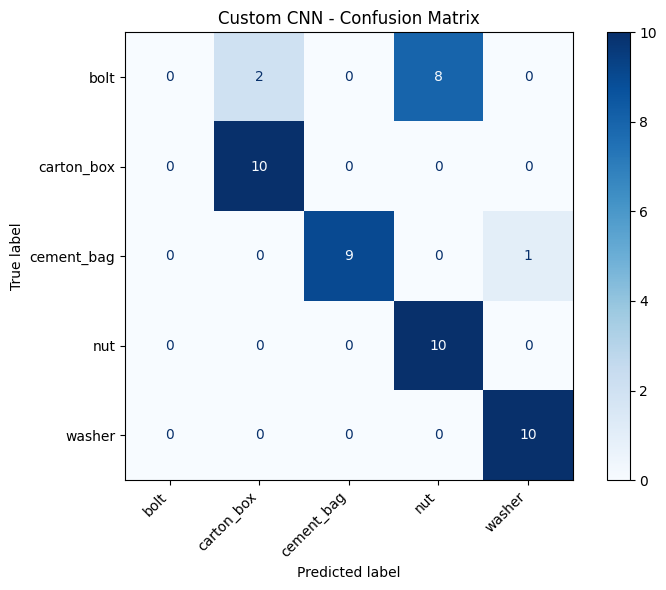

In [9]:
# Evaluate custom CNN on test set
custom_loss, custom_acc = eval_classification(
    custom_cnn, X_test_scaled, y_test,
    class_names=CLASS_NAMES,
    model_name='Custom CNN'
)

## 5. Model 2: EfficientNetV2B0 (Transfer Learning)

### Why EfficientNetV2B0?
- Used in exercises 10 and 11 — proven to work well on small image classification tasks
- Pretrained on ImageNet (14M images, 1000 classes) — massive knowledge base for feature extraction
- EfficientNet family is designed for parameter efficiency — important when fine-tuning on small data
- V2B0 is the smallest variant — good balance between capacity and overfitting risk

### Transfer Learning Strategy
1. **Load pretrained base** with `include_top=False` (remove ImageNet classification head)
2. **Freeze all base layers** initially — only train our new classification head
3. **Train for 15 epochs** with frozen base to build a good classification head
4. **Unfreeze top 20 layers** and fine-tune with a low learning rate (1e-5) for 20 more epochs

This two-phase approach prevents the randomly initialized head from producing large gradients that destroy pretrained features.

In [10]:
# Prepare data for EfficientNet (uses its own preprocessing)
def preprocess_efficientnet(image, label):
    image = keras.applications.efficientnet_v2.preprocess_input(image)
    return image, label

train_ds_effnet = train_ds.map(preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds_effnet = val_ds.map(preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_ds_effnet = test_ds.map(preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

X_test_effnet = keras.applications.efficientnet_v2.preprocess_input(X_test_raw.copy())
print(f"EfficientNet preprocessed test range: [{X_test_effnet.min():.2f}, {X_test_effnet.max():.2f}]")

EfficientNet preprocessed test range: [0.00, 255.00]


In [11]:
# Build EfficientNetV2B0 model
effnet_base = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Phase 1: Freeze base
effnet_base.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = effnet_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

effnet_model = keras.Model(inputs=inputs, outputs=outputs, name='efficientnet_v2b0')

effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"EfficientNetV2B0 base layers: {len(effnet_base.layers)}")
print(f"Trainable params (frozen base): {effnet_model.count_params() - sum(np.prod(w.shape) for w in effnet_base.trainable_weights if False):,}")
effnet_model.summary(show_trainable=True)

EfficientNetV2B0 base layers: 270
Trainable params (frozen base): 6,083,925


Model: "efficientnet_v2b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ data_augmentation           │ (None, 224, 224, 3)   │          0 │   -   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 7, 7, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 128)           │    163,968 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 5)             │        645 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 6,083,925 (23.21 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [12]:
# Phase 1: Train with frozen base
print("=" * 50)
print("Phase 1: Training classification head (base frozen)")
print("=" * 50)

effnet_model, effnet_history_p1 = train_model_ds(
    effnet_model, train_ds_effnet, val_ds_effnet,
    model_name='effnet_phase1_frozen',
    epochs=15,
    early_stopping=False
)

Phase 1: Training classification head (base frozen)
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.8650 - loss: 0.4172 - val_accuracy: 0.9700 - val_loss: 0.1140
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9775 - loss: 0.0710 - val_accuracy: 0.9800 - val_loss: 0.0979
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9825 - loss: 0.0462 - val_accuracy: 0.9800 - val_loss: 0.1064
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9925 - loss: 0.0264 - val_accuracy: 0.9700 - val_loss: 0.0966
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9975 - loss: 0.0233 - val_accuracy: 0.9700 - val_loss: 0.1073
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9900 - loss: 0.0220 - val_accuracy: 0.9800 - val_loss: 0.1072
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9975 - loss: 0.0170 - val_accuracy: 0.9700 - val_loss: 0.1074
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accur

In [13]:
# Phase 2: Fine-tune top layers of base model
print("=" * 50)
print("Phase 2: Fine-tuning top 20 layers of EfficientNet")
print("=" * 50)

effnet_base.trainable = True

# Freeze all but last 20 layers
for layer in effnet_base.layers[:-20]:
    layer.trainable = False

trainable_count = sum(1 for l in effnet_base.layers if l.trainable)
print(f"Trainable layers in base: {trainable_count}/{len(effnet_base.layers)}")

# Recompile with lower learning rate
effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

effnet_model, effnet_history_p2 = train_model_ds(
    effnet_model, train_ds_effnet, val_ds_effnet,
    model_name='effnet_phase2_finetune',
    epochs=20,
    early_stopping=True,
    patience=10
)

Phase 2: Fine-tuning top 20 layers of EfficientNet
Trainable layers in base: 20/270
Epoch 1/20


E0000 00:00:1771009252.009772  102204 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/efficientnet_v2b0_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9875 - loss: 0.0696 - val_accuracy: 0.9700 - val_loss: 0.0741
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9900 - loss: 0.0419 - val_accuracy: 0.9700 - val_loss: 0.0741
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9900 - loss: 0.0405 - val_accuracy: 0.9700 - val_loss: 0.0762
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9950 - loss: 0.0275 - val_accuracy: 0.9700 - val_loss: 0.0778
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9950 - loss: 0.0324 - val_accuracy: 0.9700 - val_loss: 0.0782
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9950 - loss: 0.0233 - val_accuracy: 0.9700 - val_loss: 0.0811
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9950 - loss: 0.0250 - val_accuracy: 0.9700 - val_loss: 0.0822
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9975 - loss: 0.0333 - val_accuracy: 0.9800 - val_loss: 0


  EfficientNetV2B0 - Classification Results
  Test Loss:     0.0756
  Test Accuracy: 0.9800 (98.00%)

              precision    recall  f1-score   support

        bolt       1.00      0.90      0.95        10
  carton_box       1.00      1.00      1.00        10
  cement_bag       1.00      1.00      1.00        10
         nut       0.91      1.00      0.95        10
      washer       1.00      1.00      1.00        10

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



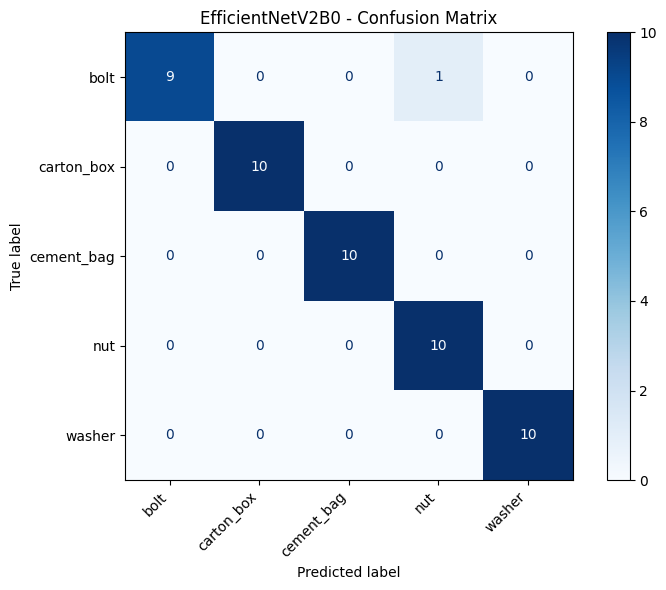

In [14]:
# Evaluate EfficientNet on test set
effnet_loss, effnet_acc = eval_classification(
    effnet_model, X_test_effnet, y_test,
    class_names=CLASS_NAMES,
    model_name='EfficientNetV2B0'
)

## 6. Model 3: MobileNetV3Small (Transfer Learning)

### Why MobileNetV3Small?
- **Lightweight architecture** designed for mobile/edge devices — interesting contrast to EfficientNet
- Much fewer parameters → less risk of overfitting on our small dataset
- Uses inverted residuals and squeeze-and-excitation blocks — different inductive bias than EfficientNet
- Practical choice: if deployed on an industrial edge device for real-time classification, MobileNet is a realistic option

### Same fine-tuning strategy as EfficientNet for fair comparison.

In [15]:
# Prepare data for MobileNet
def preprocess_mobilenet(image, label):
    image = keras.applications.mobilenet_v3.preprocess_input(image)
    return image, label

train_ds_mobile = train_ds.map(preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds_mobile = val_ds.map(preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_ds_mobile = test_ds.map(preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

X_test_mobile = keras.applications.mobilenet_v3.preprocess_input(X_test_raw.copy())
print(f"MobileNet preprocessed test range: [{X_test_mobile.min():.2f}, {X_test_mobile.max():.2f}]")

MobileNet preprocessed test range: [0.00, 255.00]


In [16]:
# Build MobileNetV3Small model
mobile_base = keras.applications.MobileNetV3Small(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Phase 1: Freeze base
mobile_base.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = mobile_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

mobile_model = keras.Model(inputs=inputs, outputs=outputs, name='mobilenet_v3_small')

mobile_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"MobileNetV3Small base layers: {len(mobile_base.layers)}")
mobile_model.summary(show_trainable=True)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
MobileNetV3Small base layers: 157


Model: "mobilenet_v3_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ data_augmentation           │ (None, 224, 224, 3)   │          0 │   -   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ MobileNetV3Small            │ (None, 7, 7, 576)     │    939,120 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 576)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 5)             │        645 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 1,013,621 (3.87 MB)

 Trainable params: 74,501 (291.02 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [17]:
# Phase 1: Train with frozen base
print("=" * 50)
print("Phase 1: Training classification head (base frozen)")
print("=" * 50)

mobile_model, mobile_history_p1 = train_model_ds(
    mobile_model, train_ds_mobile, val_ds_mobile,
    model_name='mobilenet_phase1_frozen',
    epochs=15,
    early_stopping=False
)

Phase 1: Training classification head (base frozen)
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.7725 - loss: 0.6606 - val_accuracy: 0.9400 - val_loss: 0.2158
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9500 - loss: 0.1498 - val_accuracy: 0.9400 - val_loss: 0.1598
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9700 - loss: 0.1069 - val_accuracy: 0.9600 - val_loss: 0.1211
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9800 - loss: 0.0746 - val_accuracy: 0.9600 - val_loss: 0.1134
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9875 - loss: 0.0584 - val_accuracy: 0.9600 - val_loss: 0.1171
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9825 - loss: 0.0542 - val_accuracy: 0.9600 - val_loss: 0.0983
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9875 - loss: 0.0409 - val_accuracy: 0.9600 - val_loss: 0.1004
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accura

In [18]:
# Phase 2: Fine-tune
print("=" * 50)
print("Phase 2: Fine-tuning top 30 layers of MobileNet")
print("=" * 50)

mobile_base.trainable = True

for layer in mobile_base.layers[:-30]:
    layer.trainable = False

trainable_count = sum(1 for l in mobile_base.layers if l.trainable)
print(f"Trainable layers in base: {trainable_count}/{len(mobile_base.layers)}")

mobile_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mobile_model, mobile_history_p2 = train_model_ds(
    mobile_model, train_ds_mobile, val_ds_mobile,
    model_name='mobilenet_phase2_finetune',
    epochs=20,
    early_stopping=True,
    patience=10
)

Phase 2: Fine-tuning top 30 layers of MobileNet
Trainable layers in base: 30/157
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8600 - loss: 0.3874 - val_accuracy: 0.9600 - val_loss: 0.1427
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9025 - loss: 0.2885 - val_accuracy: 0.9600 - val_loss: 0.1494
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9175 - loss: 0.2055 - val_accuracy: 0.9600 - val_loss: 0.1550
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9400 - loss: 0.1598 - val_accuracy: 0.9600 - val_loss: 0.1610
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9600 - loss: 0.1360 - val_accuracy: 0.9600 - val_loss: 0.1674
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9400 - loss: 0.1620 - val_accuracy: 0.9600 - val_loss: 0.1740
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9700 - loss: 0.0904 - val_accuracy: 0.9600 - val_loss: 0.1781
Epoch 8/20
25/25 ━━━━━━━━━━━━━


  MobileNetV3Small - Classification Results
  Test Loss:     0.1139
  Test Accuracy: 0.9800 (98.00%)

              precision    recall  f1-score   support

        bolt       1.00      0.90      0.95        10
  carton_box       1.00      1.00      1.00        10
  cement_bag       1.00      1.00      1.00        10
         nut       0.91      1.00      0.95        10
      washer       1.00      1.00      1.00        10

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



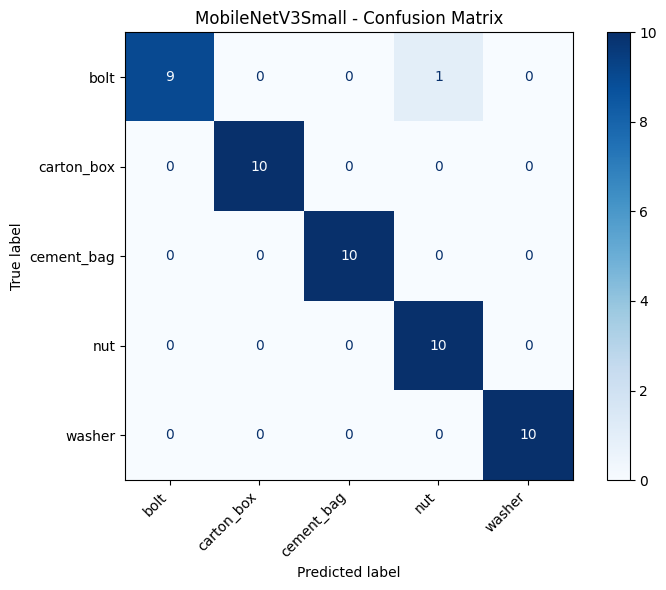

In [19]:
# Evaluate MobileNet on test set
mobile_loss, mobile_acc = eval_classification(
    mobile_model, X_test_mobile, y_test,
    class_names=CLASS_NAMES,
    model_name='MobileNetV3Small'
)

## 7. Model Comparison

### Training Curves
Let's compare how each model trained over time.

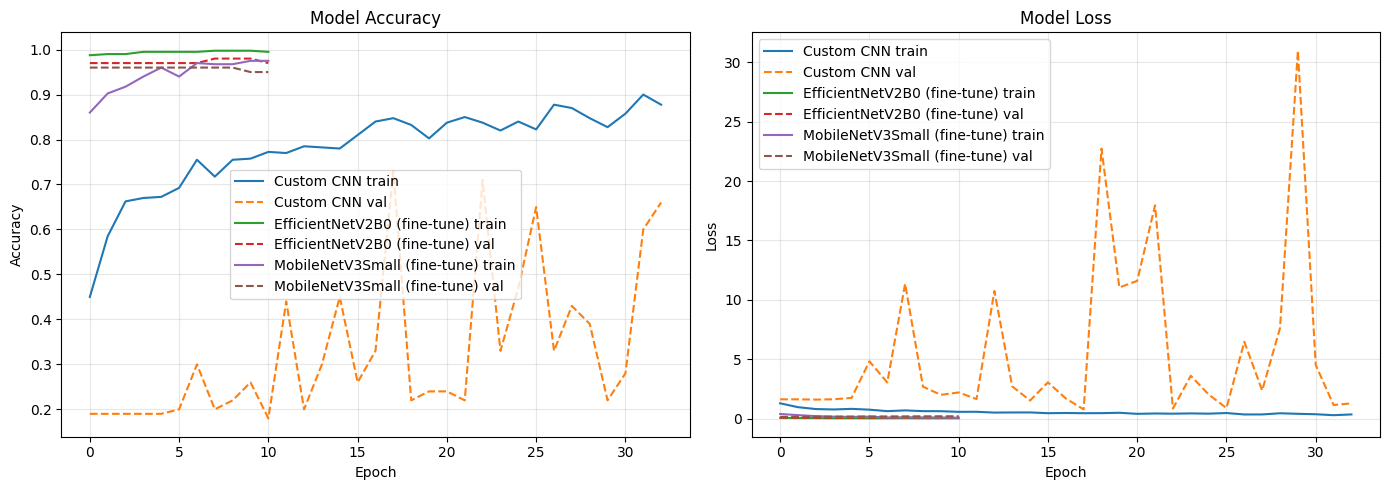

In [20]:
# Compare training curves
# For transfer learning models, we show only the fine-tuning phase (phase 2)
# since that's the main training — phase 1 is just head warmup
plot_training_history(
    [custom_history, effnet_history_p2, mobile_history_p2],
    ['Custom CNN', 'EfficientNetV2B0 (fine-tune)', 'MobileNetV3Small (fine-tune)']
)

In [21]:
# Summary comparison table
print(f"\n{'='*65}")
print(f"{'Model':<30} {'Test Acc':>10} {'Test Loss':>10} {'Params':>12}")
print(f"{'='*65}")
print(f"{'Custom CNN':<30} {custom_acc:>10.4f} {custom_loss:>10.4f} {custom_cnn.count_params():>12,}")
print(f"{'EfficientNetV2B0':<30} {effnet_acc:>10.4f} {effnet_loss:>10.4f} {effnet_model.count_params():>12,}")
print(f"{'MobileNetV3Small':<30} {mobile_acc:>10.4f} {mobile_loss:>10.4f} {mobile_model.count_params():>12,}")
print(f"{'='*65}")


Model                            Test Acc  Test Loss       Params
Custom CNN                         0.7800     0.7119      305,957
EfficientNetV2B0                   0.9800     0.0756    6,083,925
MobileNetV3Small                   0.9800     0.1139    1,013,621


## 8. GradCAM Visualization

GradCAM (Gradient-weighted Class Activation Mapping) helps us understand **what regions** each model focuses on when making predictions. We'll apply it to:
1. Correctly classified images — confirm the model looks at the right features
2. Misclassified images — understand why the model fails

We reuse the GradCAM implementation from exercise 11.

In [22]:
# Find the last conv layer name for each model

# Custom CNN: find last Conv2D layer
custom_last_conv = None
for layer in custom_cnn.layers[::-1]:
    if isinstance(layer, layers.Conv2D):
        custom_last_conv = layer.name
        break

# EfficientNet: find last conv layer in base model
effnet_last_conv = None
for layer in effnet_base.layers[::-1]:
    if 'conv' in layer.name or 'project_conv' in layer.name:
        effnet_last_conv = layer.name
        break

# MobileNet: find last conv layer in base model
mobile_last_conv = None
for layer in mobile_base.layers[::-1]:
    if 'conv' in layer.name.lower():
        mobile_last_conv = layer.name
        break

print(f"Custom CNN last conv layer: {custom_last_conv}")
print(f"EfficientNet last conv layer: {effnet_last_conv}")
print(f"MobileNet last conv layer: {mobile_last_conv}")

Custom CNN last conv layer: conv2d_5
EfficientNet last conv layer: top_conv
MobileNet last conv layer: conv_1_bn


In [23]:
# Get predictions for all test images from all models
custom_preds = np.argmax(custom_cnn.predict(X_test_scaled, verbose=0), axis=1)
effnet_preds = np.argmax(effnet_model.predict(X_test_effnet, verbose=0), axis=1)
mobile_preds = np.argmax(mobile_model.predict(X_test_mobile, verbose=0), axis=1)

# Find correct and incorrect predictions
correct_mask = (custom_preds == y_test) & (effnet_preds == y_test) & (mobile_preds == y_test)
incorrect_custom = custom_preds != y_test
incorrect_effnet = effnet_preds != y_test
incorrect_mobile = mobile_preds != y_test

print(f"All models correct: {correct_mask.sum()}/{len(y_test)}")
print(f"Custom CNN errors:  {incorrect_custom.sum()}/{len(y_test)}")
print(f"EfficientNet errors: {incorrect_effnet.sum()}/{len(y_test)}")
print(f"MobileNet errors:   {incorrect_mobile.sum()}/{len(y_test)}")

All models correct: 39/50
Custom CNN errors:  11/50
EfficientNet errors: 1/50
MobileNet errors:   1/50


GradCAM on correctly classified images (EfficientNetV2B0):


/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_35']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


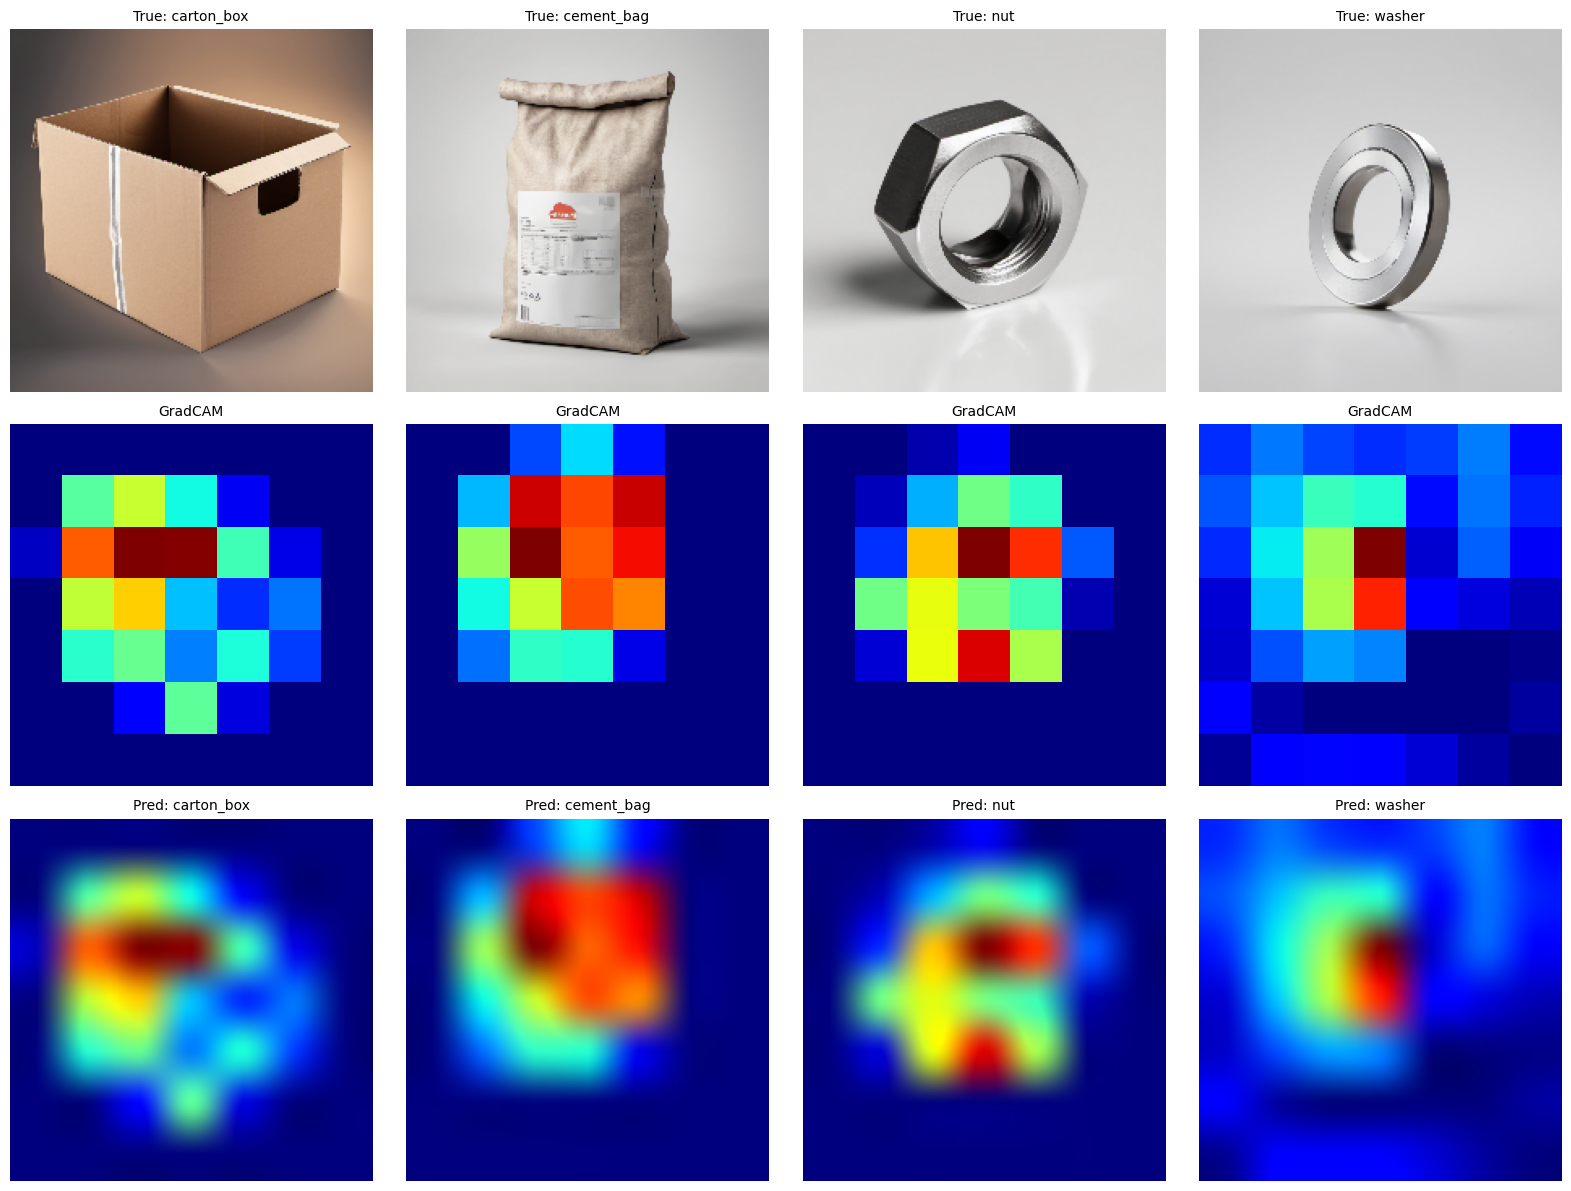

In [24]:
# GradCAM on CORRECTLY classified images (pick 4 diverse ones)
correct_indices = np.where(correct_mask)[0]
if len(correct_indices) >= 4:
    # Pick one from each class if possible
    selected_correct = []
    for cls_id in range(NUM_CLASSES):
        cls_correct = [i for i in correct_indices if y_test[i] == cls_id]
        if cls_correct:
            selected_correct.append(cls_correct[0])
        if len(selected_correct) >= 4:
            break
    # Fill remaining if needed
    for i in correct_indices:
        if i not in selected_correct:
            selected_correct.append(i)
        if len(selected_correct) >= 4:
            break
else:
    selected_correct = correct_indices[:4].tolist()

print("GradCAM on correctly classified images (EfficientNetV2B0):")
imgs_correct = X_test_raw[selected_correct] / 255.0
show_gradcam_grid(
    imgs_correct,
    y_test[selected_correct],
    effnet_preds[selected_correct],
    CLASS_NAMES,
    effnet_model,
    effnet_base,
    effnet_last_conv,
    preprocess_fn=lambda img: keras.applications.efficientnet_v2.preprocess_input(img * 255.0)
)


GradCAM on misclassified images (EfficientNetV2B0):
  Image 0: True=bolt, CustomCNN=nut, EfficientNet=bolt, MobileNet=bolt
  Image 1: True=bolt, CustomCNN=carton_box, EfficientNet=bolt, MobileNet=bolt
  Image 2: True=bolt, CustomCNN=nut, EfficientNet=bolt, MobileNet=bolt
  Image 3: True=bolt, CustomCNN=nut, EfficientNet=bolt, MobileNet=bolt


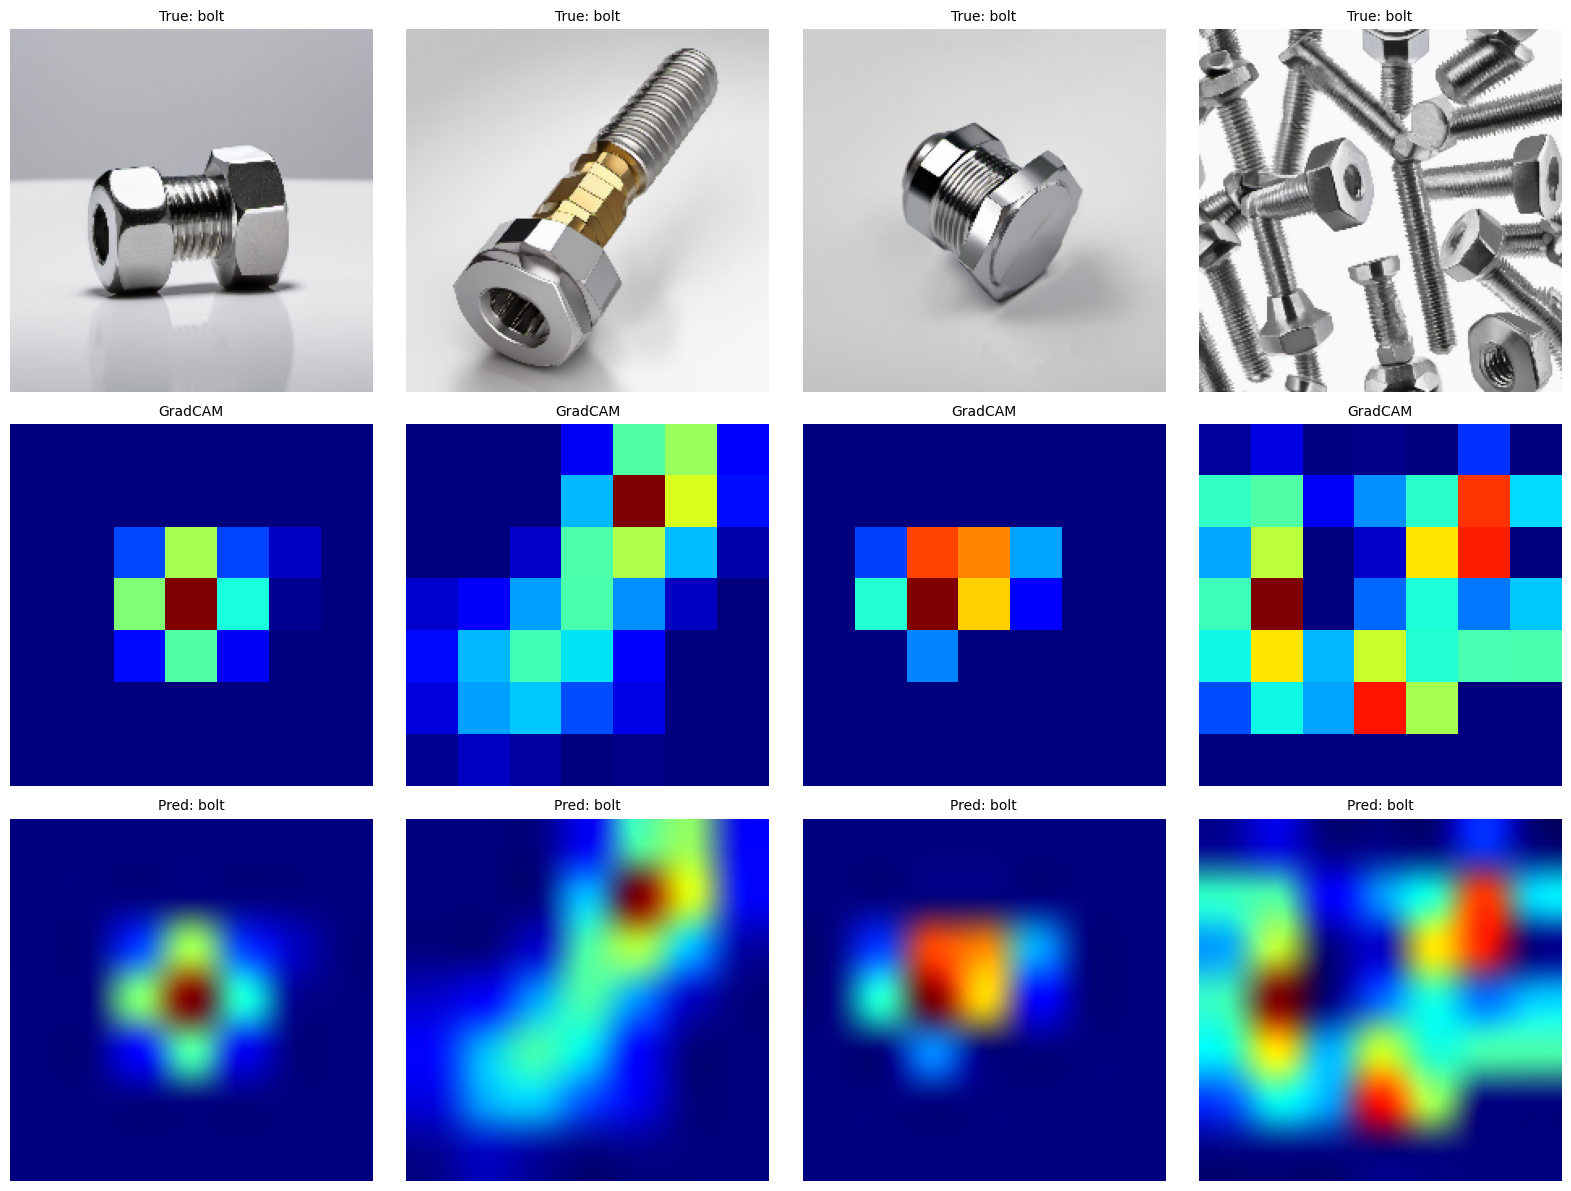

In [25]:
# GradCAM on MISCLASSIFIED images (if any exist)
any_incorrect = incorrect_custom | incorrect_effnet | incorrect_mobile
incorrect_indices = np.where(any_incorrect)[0]

if len(incorrect_indices) > 0:
    selected_incorrect = incorrect_indices[:min(4, len(incorrect_indices))]
    
    print(f"\nGradCAM on misclassified images (EfficientNetV2B0):")
    for idx in selected_incorrect:
        print(f"  Image {idx}: True={CLASS_NAMES[y_test[idx]]}, "
              f"CustomCNN={CLASS_NAMES[custom_preds[idx]]}, "
              f"EfficientNet={CLASS_NAMES[effnet_preds[idx]]}, "
              f"MobileNet={CLASS_NAMES[mobile_preds[idx]]}")
    
    imgs_incorrect = X_test_raw[selected_incorrect] / 255.0
    show_gradcam_grid(
        imgs_incorrect,
        y_test[selected_incorrect],
        effnet_preds[selected_incorrect],
        CLASS_NAMES,
        effnet_model,
        effnet_base,
        effnet_last_conv,
        preprocess_fn=lambda img: keras.applications.efficientnet_v2.preprocess_input(img * 255.0)
    )
else:
    print("All models classified all test images correctly! No misclassifications to visualize.")

/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_315']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


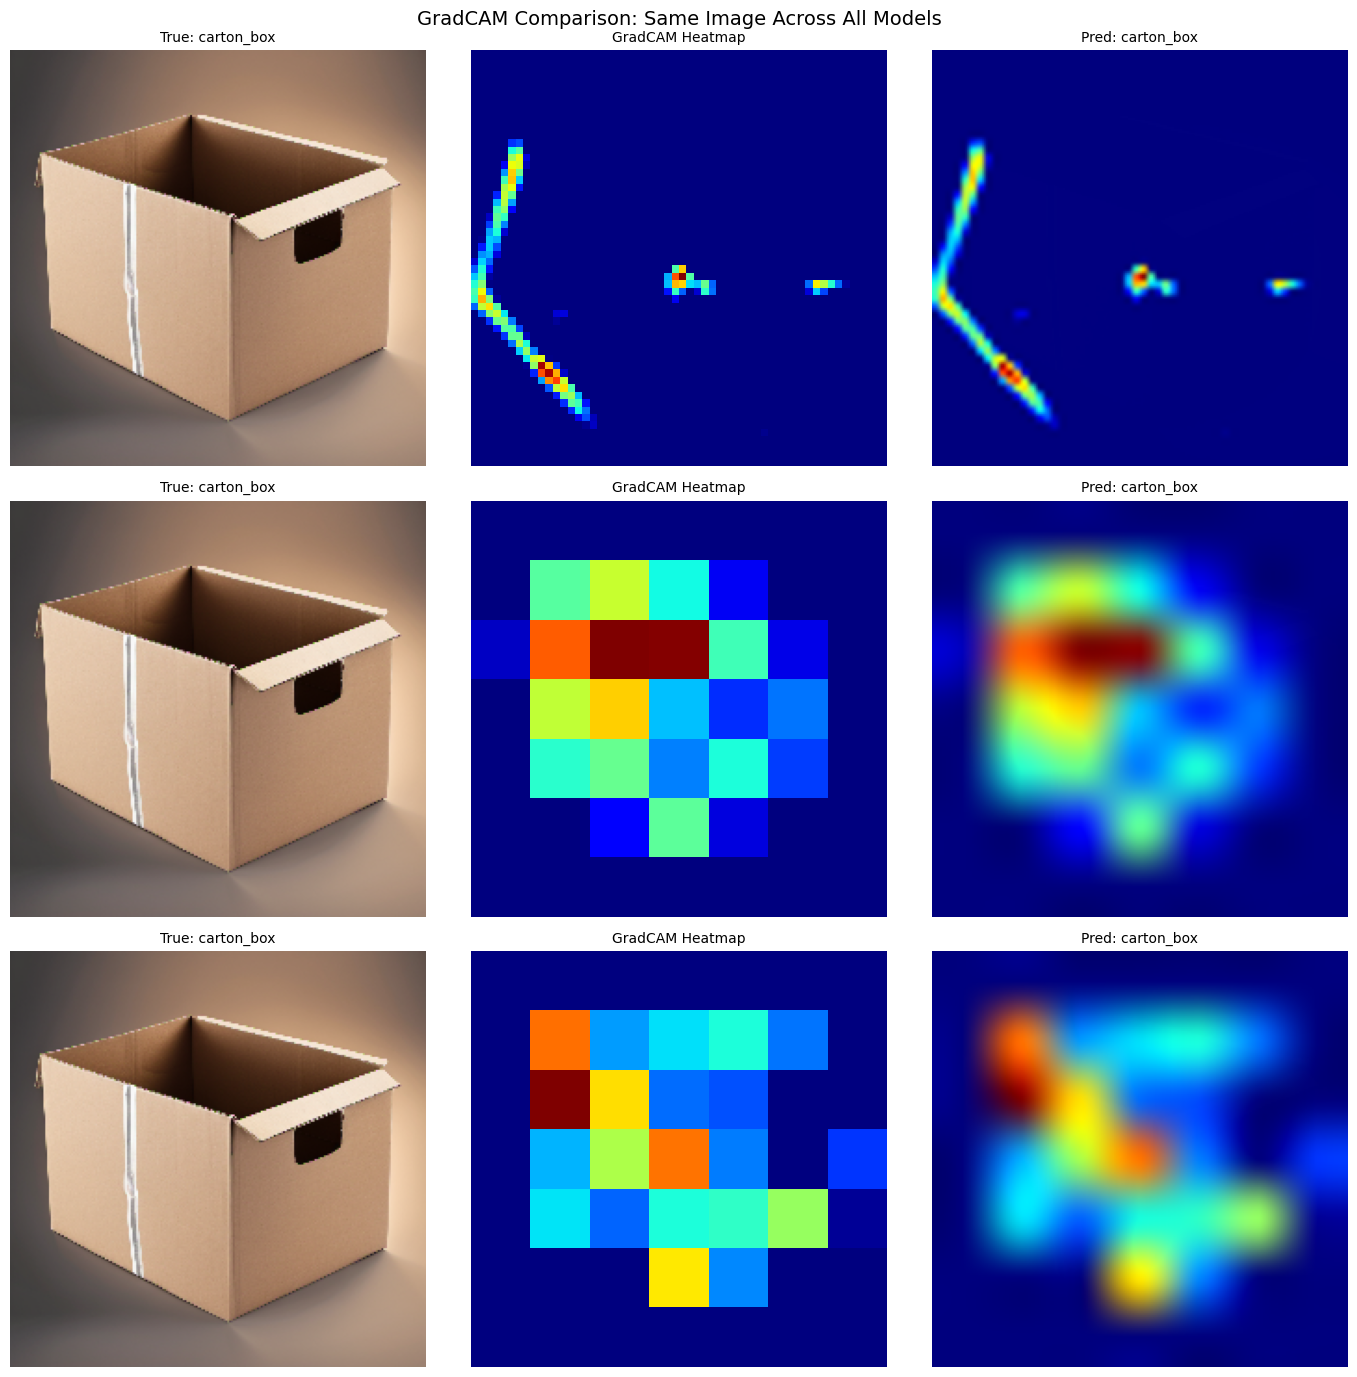

In [26]:
# GradCAM comparison: same image through all 3 models
comparison_idx = correct_indices[0] if len(correct_indices) > 0 else 0
img_display = X_test_raw[comparison_idx] / 255.0

fig, axes = plt.subplots(3, 3, figsize=(14, 14))
models_info = [
    ('Custom CNN', custom_cnn, None, custom_last_conv, X_test_scaled[comparison_idx], custom_preds[comparison_idx]),
    ('EfficientNetV2B0', effnet_model, effnet_base, effnet_last_conv, X_test_effnet[comparison_idx], effnet_preds[comparison_idx]),
    ('MobileNetV3Small', mobile_model, mobile_base, mobile_last_conv, X_test_mobile[comparison_idx], mobile_preds[comparison_idx]),
]

for row, (name, model, base, conv_name, img_preprocessed, pred) in enumerate(models_info):
    img_array = np.expand_dims(img_preprocessed, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, base, conv_name)
    superimposed = create_gradcam_visualization(img_display, heatmap)
    
    axes[row, 0].imshow(img_display)
    axes[row, 0].set_title(f"True: {CLASS_NAMES[y_test[comparison_idx]]}", fontsize=10)
    axes[row, 0].set_ylabel(name, fontsize=12, fontweight='bold')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(heatmap, cmap='jet')
    axes[row, 1].set_title("GradCAM Heatmap", fontsize=10)
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(superimposed)
    axes[row, 2].set_title(f"Pred: {CLASS_NAMES[pred]}", fontsize=10)
    axes[row, 2].axis('off')

plt.suptitle('GradCAM Comparison: Same Image Across All Models', fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
# === Save all figures to images/ directory ===
import os
import importlib
import utils
importlib.reload(utils)
from utils import eval_classification, plot_training_history, show_gradcam_grid, make_gradcam_heatmap, create_gradcam_visualization

os.makedirs('images', exist_ok=True)

# 1. Sample training images
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
for col, cls in enumerate(CLASS_NAMES):
    cls_dir = os.path.join(TRAIN_DIR, cls)
    img_files = sorted(os.listdir(cls_dir))[:2]
    for row in range(2):
        img_path = os.path.join(cls_dir, img_files[row])
        img = keras.utils.load_img(img_path, target_size=(256, 256))
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{cls}\n({img_files[row]})", fontsize=9)
        axes[row, col].axis('off')
plt.suptitle('Sample Training Images (resized to 256×256 for display)', fontsize=13)
plt.tight_layout()
plt.savefig('images/sample_training_images.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: sample_training_images.png")

# 2. Data augmentation examples
sample_batch = next(iter(train_ds))
sample_images_s = sample_batch[0][:5]
sample_labels_s = sample_batch[1][:5]
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
for i in range(5):
    axes[0, i].imshow(sample_images_s[i].numpy().astype('uint8'))
    axes[0, i].set_title(f"Original: {CLASS_NAMES[sample_labels_s[i]]}", fontsize=9)
    axes[0, i].axis('off')
    aug = data_augmentation(tf.expand_dims(sample_images_s[i], 0))
    axes[1, i].imshow(aug[0].numpy().astype('uint8'))
    axes[1, i].set_title(f"Augmented: {CLASS_NAMES[sample_labels_s[i]]}", fontsize=9)
    axes[1, i].axis('off')
plt.suptitle('Data Augmentation Examples', fontsize=13)
plt.tight_layout()
plt.savefig('images/data_augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: data_augmentation_examples.png")

# 3. Confusion matrix - Custom CNN
eval_classification(
    custom_cnn, X_test_scaled, y_test,
    class_names=CLASS_NAMES, model_name='Custom CNN',
    save_path='images/confusion_matrix_custom_cnn.png'
)
print("Saved: confusion_matrix_custom_cnn.png")

# 4. Confusion matrix - EfficientNet
eval_classification(
    effnet_model, X_test_effnet, y_test,
    class_names=CLASS_NAMES, model_name='EfficientNetV2B0',
    save_path='images/confusion_matrix_efficientnet.png'
)
print("Saved: confusion_matrix_efficientnet.png")

# 5. Confusion matrix - MobileNet
eval_classification(
    mobile_model, X_test_mobile, y_test,
    class_names=CLASS_NAMES, model_name='MobileNetV3Small',
    save_path='images/confusion_matrix_mobilenet.png'
)
print("Saved: confusion_matrix_mobilenet.png")

# 6. Training curves comparison
plot_training_history(
    [custom_history, effnet_history_p2, mobile_history_p2],
    ['Custom CNN', 'EfficientNetV2B0 (fine-tune)', 'MobileNetV3Small (fine-tune)'],
    save_path='images/training_curves_comparison.png'
)
print("Saved: training_curves_comparison.png")

# 7. GradCAM correct predictions
show_gradcam_grid(
    imgs_correct,
    y_test[selected_correct],
    effnet_preds[selected_correct],
    CLASS_NAMES,
    effnet_model,
    effnet_base,
    effnet_last_conv,
    preprocess_fn=lambda img: keras.applications.efficientnet_v2.preprocess_input(img * 255.0),
    save_path='images/gradcam_correct_predictions.png'
)
print("Saved: gradcam_correct_predictions.png")

# 8. GradCAM misclassified
show_gradcam_grid(
    imgs_incorrect,
    y_test[selected_incorrect],
    effnet_preds[selected_incorrect],
    CLASS_NAMES,
    effnet_model,
    effnet_base,
    effnet_last_conv,
    preprocess_fn=lambda img: keras.applications.efficientnet_v2.preprocess_input(img * 255.0),
    save_path='images/gradcam_misclassified.png'
)
print("Saved: gradcam_misclassified.png")

# 9. GradCAM model comparison
fig, axes = plt.subplots(3, 3, figsize=(14, 14))
models_info_s = [
    ('Custom CNN', custom_cnn, None, custom_last_conv, X_test_scaled[comparison_idx], custom_preds[comparison_idx]),
    ('EfficientNetV2B0', effnet_model, effnet_base, effnet_last_conv, X_test_effnet[comparison_idx], effnet_preds[comparison_idx]),
    ('MobileNetV3Small', mobile_model, mobile_base, mobile_last_conv, X_test_mobile[comparison_idx], mobile_preds[comparison_idx]),
]
for row, (name, model, base, conv_name, img_preprocessed, pred) in enumerate(models_info_s):
    img_array = np.expand_dims(img_preprocessed, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, base, conv_name)
    superimposed = create_gradcam_visualization(img_display, heatmap)
    axes[row, 0].imshow(img_display)
    axes[row, 0].set_title(f"True: {CLASS_NAMES[y_test[comparison_idx]]}", fontsize=10)
    axes[row, 0].set_ylabel(name, fontsize=12, fontweight='bold')
    axes[row, 0].axis('off')
    axes[row, 1].imshow(heatmap, cmap='jet')
    axes[row, 1].set_title("GradCAM Heatmap", fontsize=10)
    axes[row, 1].axis('off')
    axes[row, 2].imshow(superimposed)
    axes[row, 2].set_title(f"Pred: {CLASS_NAMES[pred]}", fontsize=10)
    axes[row, 2].axis('off')
plt.suptitle('GradCAM Comparison: Same Image Across All Models', fontsize=14)
plt.tight_layout()
plt.savefig('images/gradcam_model_comparison.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: gradcam_model_comparison.png")

print("\n=== All 9 images saved to images/ directory ===")

Saved: sample_training_images.png
Saved: data_augmentation_examples.png

  Custom CNN - Classification Results
  Test Loss:     0.6981
  Test Accuracy: 0.7800 (78.00%)

              precision    recall  f1-score   support

        bolt       0.00      0.00      0.00        10
  carton_box       0.83      1.00      0.91        10
  cement_bag       1.00      0.90      0.95        10
         nut       0.56      1.00      0.71        10
      washer       0.91      1.00      0.95        10

    accuracy                           0.78        50
   macro avg       0.66      0.78      0.70        50
weighted avg       0.66      0.78      0.70        50

Saved: confusion_matrix_custom_cnn.png


/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res


  EfficientNetV2B0 - Classification Results
  Test Loss:     0.0756
  Test Accuracy: 0.9800 (98.00%)

              precision    recall  f1-score   support

        bolt       1.00      0.90      0.95        10
  carton_box       1.00      1.00      1.00        10
  cement_bag       1.00      1.00      1.00        10
         nut       0.91      1.00      0.95        10
      washer       1.00      1.00      1.00        10

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

Saved: confusion_matrix_efficientnet.png

  MobileNetV3Small - Classification Results
  Test Loss:     0.1139
  Test Accuracy: 0.9800 (98.00%)

              precision    recall  f1-score   support

        bolt       1.00      0.90      0.95        10
  carton_box       1.00      1.00      1.00        10
  cement_bag       1.00      1.00      1.00        10
         nut       0.91      1.00      0.95    

/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_35']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Saved: gradcam_correct_predictions.png
Saved: gradcam_misclassified.png


/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/home/stas/my_git/ndl/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_315']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Saved: gradcam_model_comparison.png

=== All 9 images saved to images/ directory ===


## 9. Analysis & Conclusion

### Results Summary

| Model | Test Accuracy | Test Loss | Parameters |
|-------|:------------:|:---------:|:----------:|
| Custom CNN | 78.00% | 0.7119 | 305,957 |
| EfficientNetV2B0 | **98.00%** | **0.0756** | 6,083,925 |
| MobileNetV3Small | **98.00%** | 0.1139 | 1,013,621 |

### Key Findings

**Transfer Learning vs. Training from Scratch:**
- With only 500 training images, transfer learning models (98% accuracy) massively outperform the custom CNN (78%). This was expected — the custom CNN needs to learn all visual features from scratch with very limited data.
- The custom CNN particularly struggles with the **bolt** class — it misclassifies all 10 test bolts as nuts or carton_boxes. Bolts and nuts are both metallic hexagonal objects, and 100 training images per class isn't enough for the model to learn the distinguishing features (thread pattern, overall shape).
- Both pretrained models achieve 98% with only 1 error each — a bolt misclassified as a nut.

**EfficientNet vs. MobileNet:**
- Both achieve identical 98% test accuracy with the same single misclassification (bolt → nut)
- EfficientNet has a slightly lower test loss (0.076 vs. 0.114), suggesting more confident correct predictions
- MobileNet is **6x smaller** (1M vs. 6M params) — much more practical for edge deployment in a real industrial setting
- MobileNet also trains significantly faster due to fewer parameters

**Training Behavior:**
- Custom CNN shows severe overfitting: train accuracy reaches ~90% while validation oscillates wildly (20-70%). This is classic small-dataset behavior.
- Both pretrained models converge almost instantly in phase 1 (frozen base) — reaching 97%+ val accuracy within 1-2 epochs. The fine-tuning phase (phase 2) provides marginal improvement.
- Early stopping was essential for the custom CNN, triggering at epoch 33 and restoring weights from epoch 18.

**GradCAM Insights:**
- EfficientNet's heatmaps focus clearly on the object regions — the center of boxes, bags, nuts, and washers
- The custom CNN produces much more sparse/scattered activations (visible in the 3-model comparison), suggesting it hasn't learned robust object-level features
- For the misclassified bolt images, all models tend to focus on the hexagonal head (which looks like a nut from above)

**Dataset Observations:**
- SDXL-generated images provide high quality and consistency, but the 100 images per class aren't enough for a CNN trained from scratch
- The dataset is perfectly balanced, so class weighting wasn't needed
- 50 test images is a small test set — the difference between 78% and 98% is just 10 images

### What Could Be Improved
- More training data (200-500 per class would likely close the gap for the custom CNN)
- Mixup or CutMix augmentation to create more diverse training samples
- Learning rate scheduling (cosine annealing) for the custom CNN
- Ensemble of all three models for maximum robustness
- Testing on real photographs (not AI-generated) to assess generalization

### Note on LLM Usage
GitHub Copilot was used for code assistance and boilerplate. All architectural decisions, augmentation choices, hyperparameter selection, and analysis were done manually based on course exercises 8-11.